In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import json
import pandas as pd
from scipy.interpolate import interp1d
sns.set(style="whitegrid")

In [16]:
models = [
#     'qmix', 
    'dpp',
    'qmix', 
    'coma', 
    'iql', 
    'centralV',
    'noisemix', 
    'vdn',
    'qtran'
]

model_names = {
    'dpp': 'Q-DPP (Ours)',
    'qmix': 'QMIX', 
    'coma': 'COMA', 
    'iql': 'IQL', 
    'centralV': 'CentralV',
    'noisemix': 'MAVEN', 
    'vdn': 'VDN',
    'qtran': 'QTRAN'
}

game = 'PredatorPrey7x7-v01'
df = None

fields = [ 'return_mean_T', 'return_mean']

def smoothing(vs,p=0.95,model='qmix'):
    rsts = []
    last = vs[0]
    for i, v in enumerate(vs):
        if i == 0:
            smoothed = v
        else:
            smoothed =  last*p + (1-p)*v
        rsts.append(smoothed)
        last = smoothed
    return np.array(rsts)

for model in models:
    log_dir = '../result_final/grid/{}*/{}/*/info.json'.format(game, model)
    print(log_dir)
    log_paths = glob(log_dir)
    log_paths += glob(log_dir.replace('info.json', '*.csv'))
    print(log_paths)
    x_inx = None
    for path in log_paths:
        try:
            if 'json' in path:
                log = json.load(fp=open(path, 'r'))
                log_selected = {field:log[field] for field in fields if field in log.keys()}
            else:
#                 path = path.replsace('json', 'csv')
                log_pd = pd.read_csv(path)
#                 print(log_pd)
                log_selected = {}
                log_selected['return_mean_T']= log_pd['Step'].values
                log_selected['return_mean']= log_pd['Value'].values         
#             log_df = pd.DataFrame.from_dict(log, orient='index').transpose()
        except:
                print('read fail', path)
                continue

        y_column = 'return_mean'
        x_column = 'return_mean_T'
        x = np.asarray(log_selected[x_column])
        print(x[-1])
        y = np.asarray(log_selected[y_column])
        if len(x>1500):
            interval = int(len(x) / 1000)
            print('interval', interval)
            if interval <=0:
                continue
            x_final = x[-1]
            idxs = list(range(0,len(x),interval))
#             idxs = (int(idx) for idx in idxs)
            x = x[idxs]
            x[-1] = x_final
            y = y[idxs]
        
        if x_inx is None:
            x_inx = x

        y = smoothing(smoothing(np.asarray(y), model=model))
        x = x_inx[0:len(y)]
        print(x.shape, y.shape)
        log_df = pd.DataFrame(list(zip(x, y)), 
           columns =['Step', 'Return']) 
        log_df['Model'] = log_df['Step'].apply(lambda x: model_names[model])
        log_df['run'] = log_df['Step'].apply(lambda x: path)
        if df is None:
            df = log_df

        else:
            df = pd.concat([df, log_df], ignore_index=True)
        print(path)

df = df.dropna()
df = df.astype({'Step': 'int32', 'Return': 'float32'})

../result_final/grid/PredatorPrey7x7-v01*/dpp/*/info.json
['../result_final/grid/PredatorPrey7x7-v01/dpp/1/info.json', '../result_final/grid/PredatorPrey7x7-v01/dpp/3/info.json', '../result_final/grid/PredatorPrey7x7-v01-71-30/dpp/1/info.json']
64727
interval 0
4998430
interval 9
(1076,) (1076,)
../result_final/grid/PredatorPrey7x7-v01/dpp/3/info.json
4999635
interval 9
(1076,) (1076,)
../result_final/grid/PredatorPrey7x7-v01-71-30/dpp/1/info.json
../result_final/grid/PredatorPrey7x7-v01*/qmix/*/info.json
['../result_final/grid/PredatorPrey7x7-v01/qmix/1/info.json', '../result_final/grid/PredatorPrey7x7-v01/qmix/2/info.json', '../result_final/grid/PredatorPrey7x7-v01-71-30/qmix/1/info.json', '../result_final/grid/PredatorPrey7x7-v01/qmix/3/info.csv', '../result_final/grid/PredatorPrey7x7-v01-81-03/qmix/1/run-grid_PredatorPrey7x7-v01_qmix_1_tb_logs_qmix__2020-02-04_05-12-56-tag-return_mean.csv']
648
interval 0
100
interval 0
4999258
interval 9
(1079,) (1079,)
../result_final/grid/Predat

/Users/yingwen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


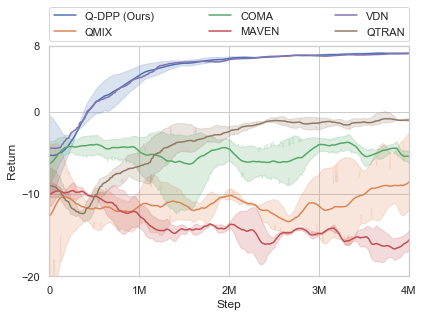

In [19]:
plt.figure(figsize=(6,4))
sns.set(font_scale=1., style="whitegrid")
ax = sns.lineplot(x="Step", y="Return",
             hue="Model", err_style='band',
             data=df)
# plt.title(game)
plt.tight_layout(pad=1)
ax.set_xlim(0., 4000000)
ax.set_ylim(-20., 8.)
ax.set_yticks([-20, -10, 0, 8])
ax.set_xticks([0, 1000000, 2000000, 3000000, 4000000])
ax.set_xticklabels(['0', '1M', '2M', '3M', '4M'])
# lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  #
# ax.axhline(y=8, linewidth=1, color='grey', ls='--')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles=handles[1:], labels=labels[1:], 
                bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
plt.savefig('{}_lc.pdf'.format(game), bbox_extra_artists=(lgd,), bbox_inches='tight', )

In [4]:
# log_paths = glob('./results/grid/{}/dpp/*/info.json'.format(game))
# path = log_paths[-1]
# log = json.load(fp=open(path, 'r'))
#         log_selected = {field:log[field] for field in fields}

In [5]:
# log.keys()

In [6]:
B = np.random.randn(9, 3)
C = np.dot(B.T,  B)
L = np.dot(B,  B.T)
print(B.shape, C.shape)

(9, 3) (3, 3)


In [7]:
u, Bs, vh = np.linalg.svd(B)
print(Bs)

[4.4567189  3.18932301 1.81914262]


In [8]:
u, Cs, vh = np.linalg.svd(C)
print(np.sqrt(Cs))

[4.4567189  3.18932301 1.81914262]


In [9]:
u, Ls, vh = np.linalg.svd(L)
print(Ls)

[1.98623433e+01 1.01717813e+01 3.30927986e+00 2.10060002e-15
 8.82982606e-16 2.33834647e-16 1.10767159e-16 5.17985872e-17
 8.18996395e-18]
